In [2]:
# 사용할 패키지를 import합니다
import sys
print('python', sys.version)

import numpy as np
import pandas as pd
import matplotlib as mpl

import glob
import pickle
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") # window
plt.rc("axes", unicode_minus=False) # x,y축 (-)부호 표시

import seaborn as sns

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


# machine learning modeling

In [27]:
def Random_Forest(X_train, X_test, y_train, y_test):
    rn = RandomForestClassifier(oob_score=True)
    model = rn.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    # Model Accuracy, how often is the classifier correct?
    APR=metrics.average_precision_score(y_test, y_pred_prob[:,1], average='weighted')
    AUC=metrics.roc_auc_score(y_test, y_pred_prob[:,1])

    return APR, AUC

def Adaboost(X_train, X_test, y_train, y_test):
    abc = AdaBoostClassifier()
    model = abc.fit(X_train, y_train)
    
    # Predict the response for test dataset
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    # Model Accuracy, how often is the classifier correct?
    APR=metrics.average_precision_score(y_test, y_pred_prob[:,1], average='weighted')
    AUC=metrics.roc_auc_score(y_test, y_pred_prob[:,1])

    return APR, AUC

In [ ]:
## ccle
ccle_genes=list(pd.read_table('../data/ccle_gene_list.txt')['gene'])

with open('../mid_result/merged_data/BRCA.pickle', 'rb') as f:
    mer_table = pickle.load(f)

## genes in CCLE database only
shared_cols=list(set(mer_table.columns)&set(ccle_genes))+['class']
mer_table=mer_table[shared_cols]

## X, y preparation
X=mer_table.drop(columns='class')
y=mer_table['class']

res_df1=pd.DataFrame(columns=['APR','AUC'])
for it in range(50):
    ## split traing and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

    ## machine learning model: (other)
    #APR, AUC=Random_Forest(X_train, X_test, y_train, y_test)
    APR, AUC=Adaboost(X_train, X_test, y_train, y_test)
    res_df1.loc[it]=[APR, AUC]

with open('../mid_result/other_ML_result/adaboost.pickle', 'wb') as f:
    pickle.dump(res_df1, f)


# Fig S5

<AxesSubplot:>

(0.5933768656716417, 0.5895335820895522, 0.5557675906183368)

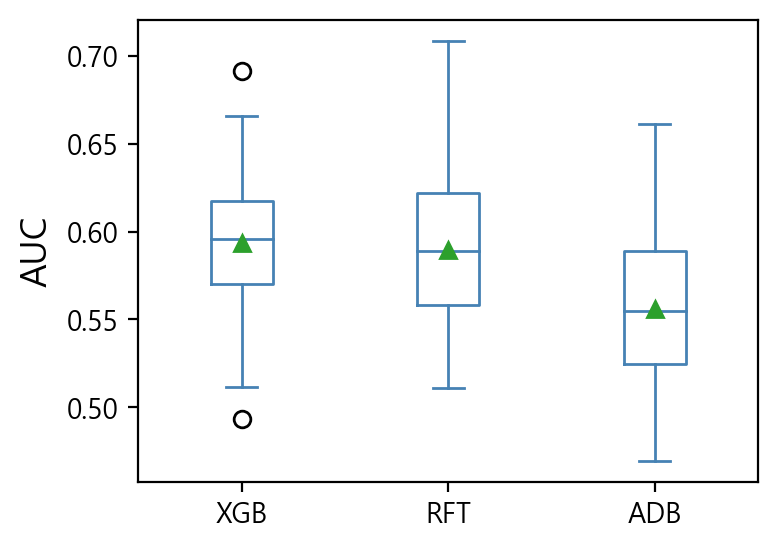

In [40]:
fig = plt.figure(figsize=(4,3), dpi=200)
ax=fig.subplots()

## fig 1a
with open("../mid_result/xgb_result/BRCA_ori0.pickle", 'rb') as f:
    xgb= pickle.load(f)
with open("../mid_result/other_ML_result/random_forest.pickle", 'rb') as f:
    rf= pickle.load(f)
with open("../mid_result/other_ML_result/adaboost.pickle", 'rb') as f:
    ad= pickle.load(f)
xgb=xgb['AUC']
xgb.name='XGB'

rf=rf['AUC']
rf.name='RFT'

ad=ad['AUC']
ad.name='ADB'

merged_df=pd.concat([xgb, rf, ad], axis=1)
merged_df.plot.box(ax=ax, color='steelblue', showmeans=True)

_=ax.set_ylabel('AUC', fontsize=13)
_=ax.tick_params(axis='both', labelsize=10)

xgb.mean(), rf.mean(), ad.mean()